# Trial of various feature selection algorithms


In [24]:
import os
from sys import stdout
import time

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
import scipy.io
from sklearn import model_selection
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.linear_model import ElasticNet,ElasticNetCV
from deap import base
from deap import creator
from deap import tools






import warnings
warnings.filterwarnings('ignore')

In [25]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    
    return
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
"""   
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        plt.show()
    return
""" 

"   \n    # Fit a line to the CV vs response\n    z = np.polyfit(y, y_c, 1)\n    with plt.style.context(('ggplot')):\n        fig, ax = plt.subplots(figsize=(9, 5))\n        ax.scatter(y_c, y, c='red', edgecolors='k')\n        #Plot the best fit line\n        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)\n        #Plot the ideal 1:1 line\n        ax.plot(y, y, color='green', linewidth=1)\n        plt.title('$R^{2}$ (CV): '+str(score_cv))\n        plt.xlabel('Predicted $^{\\circ}$Brix')\n        plt.ylabel('Measured $^{\\circ}$Brix')\n        plt.show()\n    return\n"

In [26]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
    Xc = X[:,sorted_ind]
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [27]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [28]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

In [29]:
def genetic_algorithm(X, y):

    autoscaled_X_train= X
    autoscaled_y_train=y



    # GAPLS
    creator.create('FitnessMax', base.Fitness, weights=(1.0,))  # for minimization, set weights as (-1.0,)
    creator.create('Individual', list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    min_boundary = np.zeros(X_train.shape[1])
    max_boundary = np.ones(X_train.shape[1]) * 1.0
    #print(min_boundary.shape)
    #print(max_boundary.shape)


    ###this one is for selecting at random the "individual"
    def create_ind_uniform(min_boundary, max_boundary):
        index = []
        for min, max in zip(min_boundary, max_boundary):
            index.append(random.uniform(min, max))
        return index


    toolbox.register('create_ind', create_ind_uniform, min_boundary, max_boundary)
    toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.create_ind)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)


    def evalOneMax(individual):
        individual_array = np.array(individual)
        #individual array is an array of lenght "wl" with values between 0 and 1. 
        #print("individual_array", individual_array.shape)

        selected_X_variable_numbers = np.where(individual_array > threshold_of_variable_selection)[0]
        #If an element of ind_arr is bigger than thresh it is kept. this one will be used for the selection of selected_autoscaled_X_train
        #print("selected_X_variable_numbers: ", selected_X_variable_numbers.shape)

        selected_autoscaled_X_train = autoscaled_X_train[:, selected_X_variable_numbers]
        #print("selected_autoscaled_X_train: ", selected_autoscaled_X_train.shape)


        if len(selected_X_variable_numbers):
            # cross-validation
            #print("np.linalg.matrix_rank(selected_autoscaled_X_train)", np.linalg.matrix_rank(selected_autoscaled_X_train))

            #print("AAAA ", min(np.linalg.matrix_rank(selected_autoscaled_X_train) + 1, max_number_of_components + 1))

            pls_components = np.arange(1, min(min(selected_autoscaled_X_train.shape[0],selected_autoscaled_X_train.shape[1]) + 1,
                                              max_number_of_components + 1), 1)
            #pls_components = np.arange(1, min(np.linalg.matrix_rank(selected_autoscaled_X_train) + 1,
            #                                  max_number_of_components + 1), 1)
            #print("pls components: ", pls_components)

            r2_cv_all = []

            for pls_component in pls_components:

                model_in_cv = PLSRegression(n_components=pls_component)

                #print("selected_autoscaled_X_train",selected_autoscaled_X_train)

                estimated_y_train_in_cv = np.ndarray.flatten(
                    model_selection.cross_val_predict(model_in_cv, selected_autoscaled_X_train, autoscaled_y_train, cv=fold_number))



                estimated_y_train_in_cv = estimated_y_train_in_cv * y_train.std(ddof=1) + y_train.mean()
                r2_cv_all.append(1 - sum((y_train - estimated_y_train_in_cv) ** 2) / sum((y_train - y_train.mean()) ** 2))
            #print(len(r2_cv_all))
            #print("r2_cv_all: ",r2_cv_all)
            """
            try:
                value = np.max(r2_cv_all)
            except ValueError:  #raised if `y` is empty.
                value = -999
                pass
            """
            value = np.max(r2_cv_all)

        else:
            value = -999

        return value,


    toolbox.register('evaluate', evalOneMax)
    toolbox.register('mate', tools.cxTwoPoint)
    toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)
    toolbox.register('select', tools.selTournament, tournsize=3)

    # random.seed(100)
    random.seed()
    pop = toolbox.population(n=number_of_population)

    print('Start of evolution')

    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    print('  Evaluated %i individuals' % len(pop))

    for generation in range(number_of_generation):
        print('-- Generation {0} --'.format(generation + 1))

        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < probability_of_crossover:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < probability_of_mutation:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        print('  Evaluated %i individuals' % len(invalid_ind))

        pop[:] = offspring
        fits = [ind.fitness.values[0] for ind in pop]

        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x * x for x in fits)
        std = abs(sum2 / length - mean ** 2) ** 0.5

        print('  Min %s' % min(fits))
        print('  Max %s' % max(fits))
        print('  Avg %s' % mean)
        print('  Std %s' % std)

    print('-- End of (successful) evolution --')

    best_individual = tools.selBest(pop, 1)[0]
    best_individual_array = np.array(best_individual)
    selected_X_variable_numbers = np.where(best_individual_array > threshold_of_variable_selection)[0]
    print('Selected variables : %s, %s' % (selected_X_variable_numbers, best_individual.fitness.values))

In [30]:
def _calculate_vips(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(np.matmul(np.matmul(np.matmul(t.T,t),q.T), q)).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(np.matmul(s.T, weight))/total_s)
    return vips

In [31]:
"""# Define the PLS regression object
pls = PLSRegression(n_components=8)
# Fit data
pls.fit(X_train, y_train)
# Plot spectra
plt.figure(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(211)
    plt.plot(wl, X_train.T)
    plt.ylabel('First derivative absorbance spectra')
    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(wl, np.abs(pls.coef_[:,0])) ###this is the interesting line!!!
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absolute value of PLS coefficients')
    plt.show()
"""

"# Define the PLS regression object\npls = PLSRegression(n_components=8)\n# Fit data\npls.fit(X_train, y_train)\n# Plot spectra\nplt.figure(figsize=(8,9))\nwith plt.style.context(('ggplot')):\n    ax1 = plt.subplot(211)\n    plt.plot(wl, X_train.T)\n    plt.ylabel('First derivative absorbance spectra')\n    ax2 = plt.subplot(212, sharex=ax1)\n    plt.plot(wl, np.abs(pls.coef_[:,0])) ###this is the interesting line!!!\n    plt.xlabel('Wavelength (nm)')\n    plt.ylabel('Absolute value of PLS coefficients')\n    plt.show()\n"

# Data loading

In [15]:
x_df = pd.read_csv('./avg_basic_noPure.csv', sep = ',')
#x_df = pd.read_csv('./avg_snv_noPure.csv', sep = ',')
#x_df = pd.read_csv('./avg_norm_noPure.csv', sep = ',')
#x_df = pd.read_csv('./avg_sum_noPure.csv', sep = ',')
#x_df = pd.read_csv('./avg_max_noPure.csv', sep = ',')





x_df= x_df.drop(columns=['ref_number'])
values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

#print(values)
#print(type(values))
print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(39, 4093)
(4093,)
39


,188.195100,188.260100,188.325000,188.390000,188.455000,188.520000,188.585000,188.650000,188.714900,188.779900,...,440.246900,440.300000,440.353000,440.406100,440.459200,440.512300,440.565300,440.618400,440.671400,440.724500
0,-184.782590,-142.771691,-211.611903,-74.716436,-191.711076,-81.705682,-65.373806,-50.158105,-97.774325,-36.380884,...,561.557713,911.658148,1495.459997,1787.501481,1996.755533,1307.022316,738.430016,368.259688,288.603690,177.639571
1,-162.286708,-120.204213,-190.604433,-57.331834,-180.018894,-72.890256,-61.998903,-49.910487,-100.263239,-45.839400,...,94.097287,-80.198917,44.280231,-73.350062,76.051910,16.016099,29.590892,-44.866568,13.480121,-59.674341
2,-142.312187,-103.246130,-172.208607,-40.503352,-168.640820,-63.009081,-58.113513,-43.707430,-89.722967,-35.914072,...,88.017407,-64.563215,64.213176,-50.727613,87.894063,20.868313,30.014412,-43.734857,22.502560,-54.771119
3,-169.235674,-126.696030,-195.678705,-62.390165,-185.192007,-78.513909,-68.353623,-53.619616,-101.336422,-45.666970,...,131.700731,50.550810,233.125212,179.782200,332.993874,167.289254,96.815663,-14.124444,33.144156,-48.287020
4,-190.877030,-147.836585,-217.709469,-80.805200,-198.841861,-87.441346,-70.088398,-56.858238,-106.887037,-46.276677,...,344.718794,543.213258,972.193401,1153.471610,1360.025032,831.793674,441.493731,178.911875,155.585253,62.650059
5,-154.105588,-113.856953,-182.951300,-51.622475,-176.399424,-71.066100,-62.370821,-47.854772,-95.197226,-40.715537,...,99.748205,-0.793698,172.230079,112.132459,277.950193,144.878164,122.466486,70.011375,165.134215,111.909615
6,-140.001875,-103.063412,-168.928634,-39.762395,-167.056010,-63.616411,-58.344888,-42.495224,-87.827706,-33.332558,...,88.960713,-58.041083,70.895307,-45.297363,89.001297,17.636189,23.170219,-48.748025,18.078852,-60.044378
7,-191.445602,-146.400889,-216.551188,-79.334196,-197.121517,-85.328088,-69.289755,-56.899240,-104.798993,-42.934824,...,402.655696,764.287340,1318.158394,1616.662146,1860.130127,1155.892785,613.417081,319.366071,305.734344,228.569571
8,-161.613011,-119.594180,-190.579256,-57.591704,-179.798396,-71.500497,-63.859660,-49.775479,-99.542592,-46.132297,...,90.944327,-69.184980,64.396275,-42.274096,111.321506,35.720242,33.641798,-40.585274,17.881268,-50.515293
9,-163.196523,-123.894857,-191.477505,-58.544721,-181.829142,-76.041554,-66.945439,-52.322273,-99.170752,-39.603970,...,241.419215,316.742156,638.255303,711.619329,897.209561,538.986156,286.936266,82.701282,84.746502,-7.317532


[[188.1951]
 [188.2601]
 [188.325 ]
 ...
 [440.6184]
 [440.6714]
 [440.7245]]
wl shape:  (4093, 1)


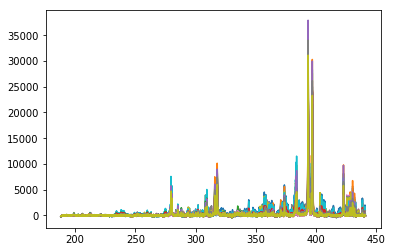

In [16]:
#This is just for visualizing the various plots of the samples


mat = scipy.io.loadmat("./data/004_O02_200Hz_QS295us_Trig1430_exp1ms.mat")
wl= mat["wl"]
print(wl)
print("wl shape: ", wl.shape)

for i in range(len(values)):
    plt.plot(wl, values[i])
    #plt.show() #comment this one to have unique plot instead of multiple ones
#range(len(dfs))
#"""


In [17]:
print(wl[0])
print(wl[-1])

[188.1951]
[440.7245]


In [18]:
df_y = pd.read_csv('./slag_concentration_noPure.csv')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

y_values=df_y.values
y_all=pd.DataFrame(y_values[:,1:-2])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(39, 19)


,ref_number,ref_name,S,CaO,CaF2,MgO,Al2O3,SiO2,FeO,MnO,Cr2O3,P2O5,V2O5,TiO2,MoO3,NiO,Na2O,K2O,NbO
0,0,H06,0.030,45.3,0.23,15.90,4.34,16.50,18.90,1.29,0.10,0.30,0.11,1.10,0.00,0.02,0.01,0.02,0.05
1,2,U08,0.200,53.0,0.00,8.94,25.50,11.80,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,3,O02,0.000,41.3,1.20,7.90,3.80,35.30,1.30,2.00,3.90,0.01,0.10,0.83,0.00,0.07,0.00,0.00,0.00
3,4,_F100,0.040,14.1,0.00,3.90,25.10,40.90,3.90,0.11,0.13,0.04,0.00,0.81,0.00,0.00,5.40,5.40,0.00
4,5,H09,0.033,32.8,0.01,10.60,7.30,14.30,33.20,2.75,0.42,0.32,0.09,1.12,0.00,0.02,0.04,0.03,0.05
5,6,U04,0.000,41.0,2.81,18.40,5.72,25.40,3.46,0.49,1.08,0.00,0.40,0.22,0.00,0.00,0.00,0.00,0.00
6,7,O05,0.000,39.2,1.10,8.40,3.70,34.30,1.70,1.30,9.30,0.01,0.11,0.92,0.00,0.38,0.00,0.00,0.00
7,8,U03,0.000,33.4,1.72,7.20,6.70,5.85,35.00,3.79,2.05,0.20,0.30,0.45,1.06,0.00,0.00,0.00,0.00
8,9,U12,0.300,44.5,0.00,24.40,22.10,7.54,0.47,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,10,H12,0.030,36.4,0.01,17.40,4.31,12.80,27.70,2.86,2.59,0.27,0.09,0.77,0.00,0.02,0.01,0.04,0.06


In [42]:
y_val = concentration[:,9] #7-Si, 8-Fe, 9-Mn, 5-Mg 
print(y_val)
print(y_val.shape)
y_df= pd.DataFrame(y_val)
#y_df

[1.29 0.0 2.0 0.11 2.75 0.49 1.3 3.79 0.0 2.86 3.35 2.72 2.0 2.8 5.82 1.21
 0.19 1.1 1.26 0.0 2.84 0.0 0.36 3.3 3.0 1.72 1.6 4.39 5.32 0.14 1.99 0.7
 0.33 2.1 0.41 1.3 3.5 1.36 0.42]
(39,)


50% completed
Suggested number of components:  3



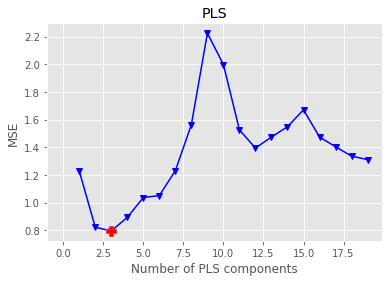

R2 calib: 0.780
R2 CV: 0.646
MSE calib: 0.494
MSE CV: 0.796


In [43]:
optimise_pls_cv(x_df, y_df, 20, plot_components=True) 

In [61]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
#X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

print(y_test)

(31, 4093) (31, 1)
(8, 4093) (8, 1)
       0
0   1.29
10  3.35
16  0.19
20  2.84
5   0.49
34  0.41
38  0.42
37  1.36


R2_pred:  -2.6000782408798964
RMSE:  2.124754689581167



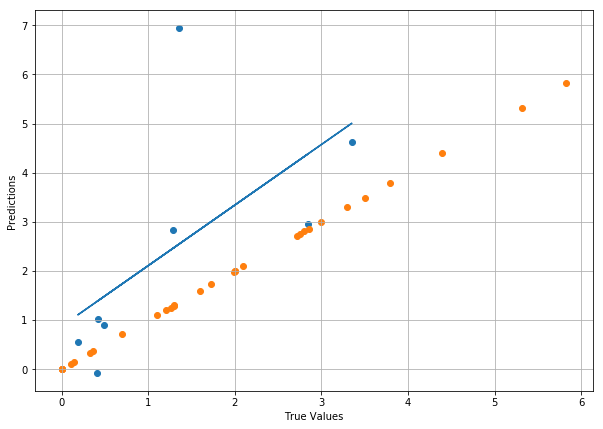

In [62]:

pls =  PLSRegression(n_components=20)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.savefig("../basic_PLS.png")
plt.grid(True)
plt.show()

R^2_pred:  -0.056570134174886766
RMSE:  1.1510706805482571 



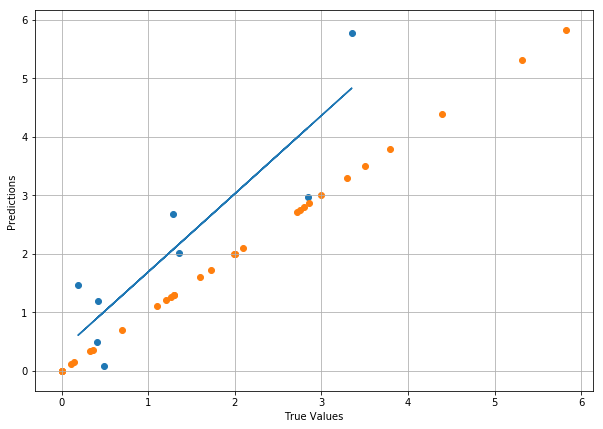

In [63]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
y_pred1 = lm.predict(X_train)

rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("R^2_pred: ", r2)
print("RMSE: ", rmse, "\n")


b=np.append(y_test, predictions, axis=1)

#print("[real, predictions]")
#print(b)
plt.figure(figsize=(10,7))
plt.scatter(y_test, predictions)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, predictions).predict(y_test) )
plt.xlabel('True Values')
plt.savefig("../basic_Linear.png")
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [64]:
alphas = [0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0000, R2:1.00, MSE:8.63, RMSE:2.94
Alpha:0.0000, R2:1.00, MSE:8.63, RMSE:2.94
Alpha:0.0000, R2:1.00, MSE:8.63, RMSE:2.94
Alpha:0.0001, R2:1.00, MSE:8.64, RMSE:2.94
Alpha:0.0010, R2:1.00, MSE:10.41, RMSE:3.23
Alpha:0.0100, R2:1.00, MSE:6.66, RMSE:2.58
Alpha:0.1000, R2:1.00, MSE:3.33, RMSE:1.82
Alpha:0.3000, R2:1.00, MSE:1.97, RMSE:1.40
Alpha:0.5000, R2:1.00, MSE:1.77, RMSE:1.33
Alpha:0.7000, R2:1.00, MSE:1.52, RMSE:1.23
Alpha:1.0000, R2:0.99, MSE:1.19, RMSE:1.09


R^2:  -5.884381899790786
RMSE:  2.938226719475273 



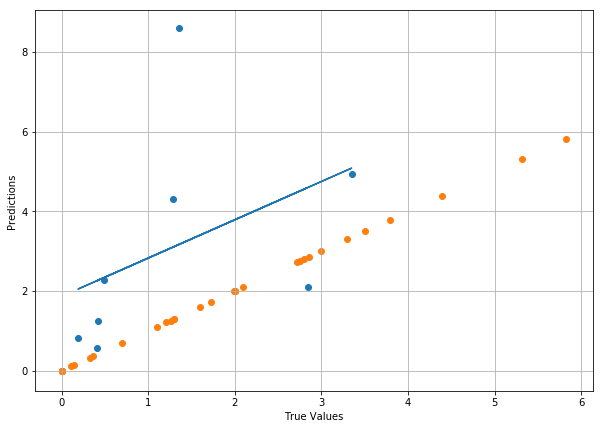

In [65]:
model = ElasticNet(alpha=0.000001).fit(X_train,y_train)   
score = model.score(X_train, y_train)
#print("Train score: ", score)
pred_y = model.predict(X_test)
y_pred1 = model.predict(X_train)

rmse = sqrt(mean_squared_error(y_test, pred_y))
r2 = r2_score(y_test, pred_y)
print("R^2: ", r2)
print("RMSE: ", rmse, "\n")

plt.figure(figsize=(10,7))
plt.scatter(y_test, pred_y)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, pred_y).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.savefig("../basic_ElasticNet.png")
plt.grid(True)
plt.show()

In [66]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(8,)
(31,)


R^2:  0.6679161658348193
RMSE:  0.6453223312872413 

[real, predictions]
[[1.29 2.412344000000008]
 [3.35 3.3567239999999887]
 [0.19 0.6227479999999941]
 [2.84 3.4802079999999878]
 [0.49 0.9362479999999958]
 [0.41 0.7130199999999972]
 [0.42 0.7674359999999942]
 [1.36 2.3910280000000057]]


Text(72.625, 0.5, 'Predictions')

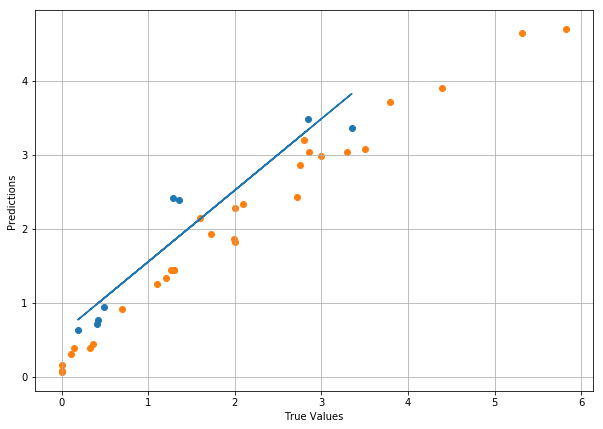

In [67]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 2500, max_depth=30, random_state = 42)
# Train the model on training data

rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
y_pred1 = rf.predict(X_train)

rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("R^2: ", r2)
print("RMSE: ", rmse, "\n")


y_test= y_test.reshape((len(y_test), 1))
y_pred1= y_pred1.reshape((len(y_pred1), 1))
predictions=predictions.reshape((len(y_test), 1))

#print((y_test, predictions))

b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.figure(figsize=(10,7))
plt.scatter(y_test, predictions)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, predictions).predict(y_test) )
plt.grid(True)
plt.savefig("../basic_RF.png")
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [20]:
wl=wl.astype('float32')

In [67]:
x_df.T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
252.071400,-7.864691,-122.419869,-45.938542,-74.248689,113.773646,117.523648,-46.131274,-34.186038,81.436124,242.174780,...,-11.939907,-68.529632,-78.189487,143.780849,136.377916,233.596703,1.697015,74.629782,154.126083,181.647922
252.201700,-32.876223,-121.975190,-72.597810,-88.550836,44.218164,28.773685,-59.723018,-55.433807,17.374412,126.912135,...,-59.197878,-73.066960,-92.605431,58.743087,41.772137,118.400946,-77.178520,7.706264,83.776126,84.686353
252.331900,-81.441809,-183.580510,-135.657078,-140.577119,13.704347,-0.176279,-111.939761,-97.281576,-15.946560,124.316155,...,-88.055848,-136.718573,-142.240124,27.589938,15.984538,74.621854,-86.508601,-33.717255,37.943409,64.796209
252.462200,34.100714,-67.385822,-23.249675,-24.499950,151.315527,167.373754,0.843499,7.020658,126.436168,319.220170,...,33.919516,-22.941610,-28.562312,173.013708,177.772694,243.342761,52.161320,110.992556,191.317585,233.334627
252.592400,-8.329733,-101.341118,-63.075597,-75.181390,114.676703,123.123781,-32.623234,-47.677101,100.189261,283.457508,...,-7.438448,-70.450351,-65.259489,145.360547,142.772965,188.146997,20.513063,56.069029,145.967616,192.087315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429.270300,45.829415,-46.334756,-13.052112,-35.509030,-37.513078,-29.982800,13.238299,1.178094,21.374104,-0.991572,...,48.842055,-21.822062,-9.566722,-9.351451,-68.212020,7.702046,-66.396315,-26.006831,-0.002719,42.854604
429.380600,-58.928506,-129.158287,-82.745375,-105.136672,-93.661145,-112.469232,-57.418883,-55.443555,-32.246530,-39.530775,...,-37.016277,-107.254400,-94.798098,-71.616581,-104.077373,-46.237878,-140.879641,-90.243253,-60.984722,-9.582645
429.491000,-100.591822,-148.631798,-108.538624,-132.660848,-119.142531,-134.580649,-87.451055,-86.315192,-35.719011,-73.369968,...,-60.741269,-113.315293,-127.029459,-83.727854,-118.760890,-74.136125,-150.408402,-108.746328,-78.794301,-21.912747
429.601300,-116.011889,-188.155299,-121.998532,-151.702258,-138.832243,-150.592057,-95.233222,-112.586823,-66.747045,-94.842491,...,-92.066256,-146.290464,-137.635813,-101.377583,-150.505005,-114.992699,-160.346245,-129.116063,-100.672840,-51.421419


In [21]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x_df, y_df, test_size=0.2, random_state = 13)
print(Ytest)

Xtrain=Xtrain.values.astype('float32')
Ytrain=Ytrain.values.astype('float32')
Xtest=Xtest.values.astype('float32')
Ytest=Ytest.values.astype('float32')

        0
17   0.36
19   0.18
23   0.16
1    0.18
7    0.78
15  9.362
26  0.185


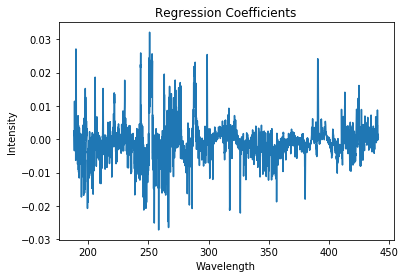

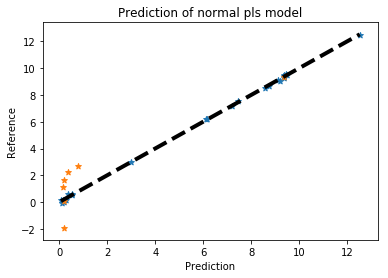

before feature selection
R2_pred:  0.7893912721802439
RMSE:  1.4571049438694204


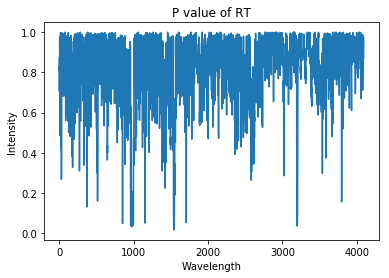

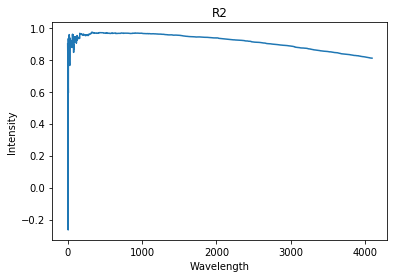

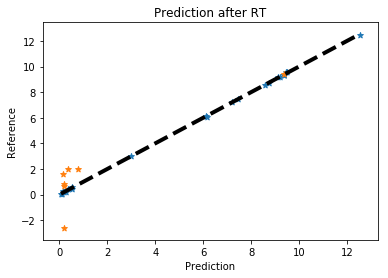

after feature selection
R2_pred:  0.7909471981837097
RMSE:  1.451712597792537


In [22]:
ncomp=10

plsModel = PLSRegression(n_components=ncomp)
plsModel.fit(Xtrain, Ytrain)
T, P, U, Q, W, C, beta = plsModel.x_scores_, plsModel.x_loadings_, plsModel.y_scores_, plsModel.y_loadings_, plsModel.x_weights_, plsModel.y_weights_, plsModel.coef_
plt.plot(wl, beta[0:])
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("Regression Coefficients")
plt.savefig("./Image1_RegressionCoefficient_PLS.png")
plt.show()

# Prediction result of pls model
Ytrain_hat = plsModel.predict(Xtrain)
Ytest_hat = plsModel.predict(Xtest)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, Ytrain_hat, marker='*')
plt.scatter(Ytest, Ytest_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction of normal pls model")
plt.savefig("./Image2_PredictionPLS.png")
plt.show()

r2 = r2_score(Ytest, Ytest_hat)
rmse = sqrt(mean_squared_error(Ytest, Ytest_hat))
print("before feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)


# P value of RT
rtModel = RT(Xtrain, Ytrain, ncomp)
rtModel.calcCriteria()
plt.plot(rtModel.criteria)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("P value of RT")
plt.savefig("./Image3_P_vale.png")
plt.show()

# Feature ranking efficienty by stability of RT
rtModel.evalCriteria(cv=5)
plt.plot(rtModel.featureR2)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("R2")
plt.savefig("./Image4_R2.png")
plt.show()

# Prediction results after feature selection by RT
XtrainNew, XtestNew = rtModel.cutFeature(Xtrain, Xtest)
plsModelNew = PLSRegression(n_components=ncomp)
plsModelNew.fit(XtrainNew, Ytrain)
YtrainNew_hat = plsModelNew.predict(XtrainNew)
YtestNew_hat = plsModelNew.predict(XtestNew)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, YtrainNew_hat, marker='*')
plt.scatter(Ytest, YtestNew_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction after RT")
plt.savefig("./Image5_Prediction_RT.png")
plt.show()

r2 = r2_score(Ytest, YtestNew_hat)
rmse = sqrt(mean_squared_error(Ytest, YtestNew_hat))
print("after feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)

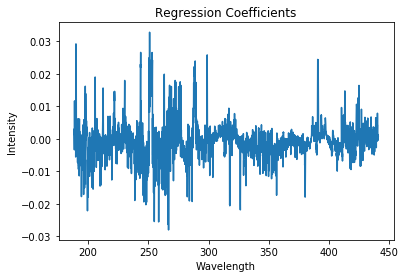

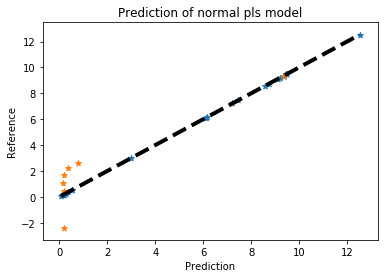

before feature selection
R2_pred:  0.7648993387003173
RMSE:  1.5394995797996531


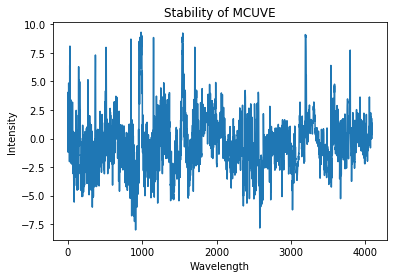

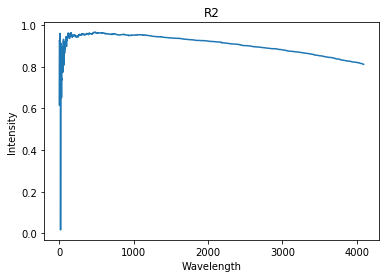

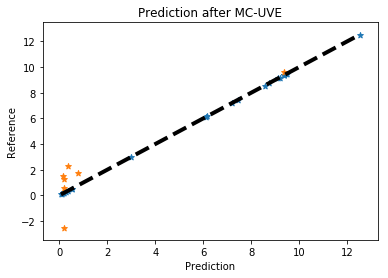

after feature selection
R2_pred:  0.7835349941754673
RMSE:  1.4772244869774245


In [23]:
ncomp=20

plsModel = PLSRegression(n_components=ncomp)
plsModel.fit(Xtrain, Ytrain)
T, P, U, Q, W, C, beta = plsModel.x_scores_, plsModel.x_loadings_, plsModel.y_scores_, plsModel.y_loadings_, plsModel.x_weights_, plsModel.y_weights_, plsModel.coef_
plt.plot(wl, beta[0:])
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("Regression Coefficients")
plt.savefig("./Image1_RegressionCoefficient_PLS.png")
plt.show()

# Prediction result of pls model
Ytrain_hat = plsModel.predict(Xtrain)
Ytest_hat = plsModel.predict(Xtest)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, Ytrain_hat, marker='*')
plt.scatter(Ytest, Ytest_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction of normal pls model")
plt.savefig("./Image2_PredictionPLS.png")
plt.show()

r2 = r2_score(Ytest, Ytest_hat)
rmse = sqrt(mean_squared_error(Ytest, Ytest_hat))
print("before feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)


# Stability of MC-UVE
mcModel = MCUVE(Xtrain, Ytrain, ncomp)
mcModel.calcCriteria()
plt.plot(mcModel.criteria)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("Stability of MCUVE")
plt.savefig("./Image3_Stability.png")
plt.show()

# Feature ranking efficienty by stability of MC-UVE
mcModel.evalCriteria(cv=5)
plt.plot(mcModel.featureR2)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("R2")
plt.savefig("./Image4_R2.png")
plt.show()

# Prediction results after feature selection by MC-UVE
XtrainNew, XtestNew = mcModel.cutFeature(Xtrain, Xtest)
plsModelNew = PLSRegression(n_components=ncomp)
plsModelNew.fit(XtrainNew, Ytrain)
YtrainNew_hat = plsModelNew.predict(XtrainNew)
YtestNew_hat = plsModelNew.predict(XtestNew)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, YtrainNew_hat, marker='*')
plt.scatter(Ytest, YtestNew_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction after MC-UVE")
plt.savefig("./Image5_Prediction_MC_UVE.png")
plt.show()

r2 = r2_score(Ytest, YtestNew_hat)
rmse = sqrt(mean_squared_error(Ytest, YtestNew_hat))
print("after feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)

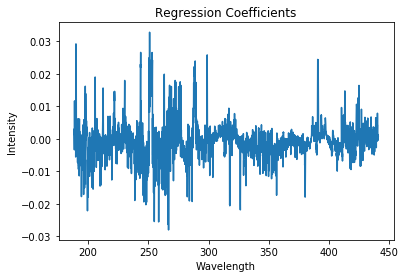

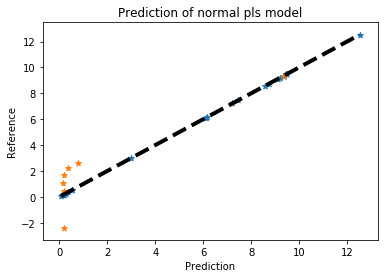

before feature selection
R2_pred:  0.7648993387003173
RMSE:  1.5394995797996531


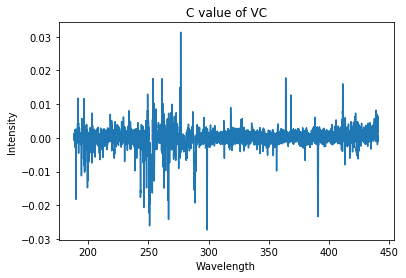

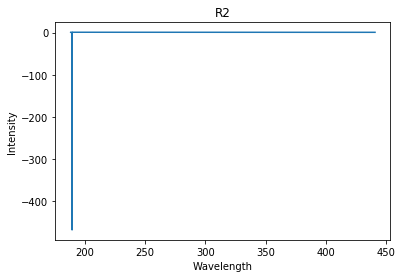

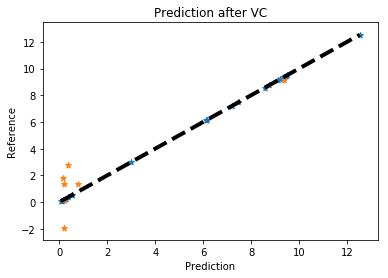

after feature selection
R2_pred:  0.7876026277607628
RMSE:  1.4632792664957124


In [24]:
ncomp=20

plsModel = PLSRegression(n_components=ncomp)
plsModel.fit(Xtrain, Ytrain)
T, P, U, Q, W, C, beta = plsModel.x_scores_, plsModel.x_loadings_, plsModel.y_scores_, plsModel.y_loadings_, plsModel.x_weights_, plsModel.y_weights_, plsModel.coef_
plt.plot(wl, beta[0:])
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("Regression Coefficients")
plt.savefig("./Image1_RegressionCoefficient_PLS.png")
plt.show()

# Prediction result of pls model
Ytrain_hat = plsModel.predict(Xtrain)
Ytest_hat = plsModel.predict(Xtest)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, Ytrain_hat, marker='*')
plt.scatter(Ytest, Ytest_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction of normal pls model")
plt.savefig("./Image2_PredictionPLS.png")
plt.show()


r2 = r2_score(Ytest, Ytest_hat)
rmse = sqrt(mean_squared_error(Ytest, Ytest_hat))
print("before feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)



# C value of VC
vcModel = VC(Xtrain, Ytrain, ncomp, nrep=7000)
vcModel.calcCriteria()
plt.plot(wl, vcModel.criteria)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("C value of VC")
plt.savefig("./Image3_C_vale.png")
plt.show()

# Feature ranking efficienty by stability of VC
vcModel.evalCriteria(cv=5)
plt.plot(wl, vcModel.featureR2)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("R2")
plt.savefig("./Image4_R2.png")
plt.show()

# Prediction results after feature selection by VC
XtrainNew, XtestNew = vcModel.cutFeature(Xtrain, Xtest)

plsModelNew = PLSRegression(n_components=min([ncomp, rank(XtrainNew)]))
#plsModelNew = PLSRegression(n_components=ncomp)

plsModelNew.fit(XtrainNew, Ytrain)
YtrainNew_hat = plsModelNew.predict(XtrainNew)
YtestNew_hat = plsModelNew.predict(XtestNew)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, YtrainNew_hat, marker='*')
plt.scatter(Ytest, YtestNew_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction after VC")
plt.savefig("./Image5_Prediction_VC.png")
plt.show()

r2 = r2_score(Ytest, YtestNew_hat)
rmse = sqrt(mean_squared_error(Ytest, YtestNew_hat))
print("after feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)

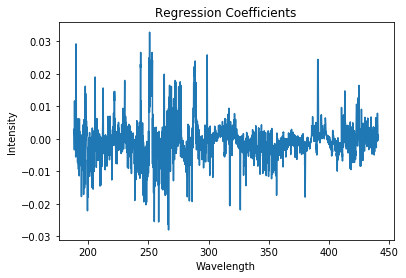

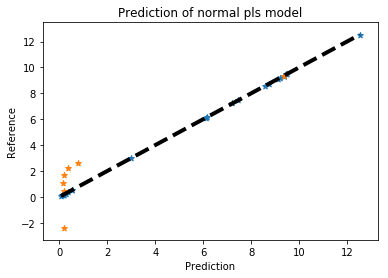

before feature selection
R2_pred:  0.7649017216897375
RMSE:  1.539491777566161


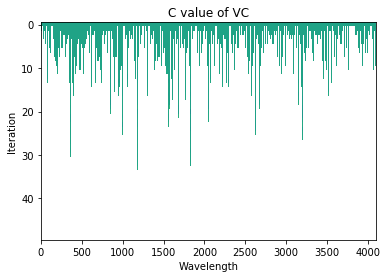

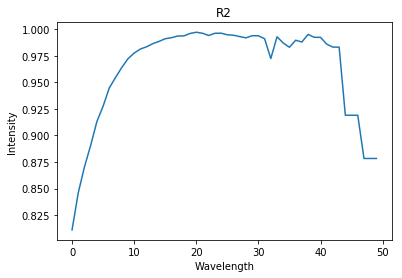

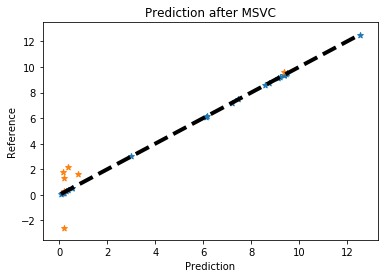

after feature selection
R2_pred:  0.7767742300313683
RMSE:  1.5001158996983837


In [25]:
ncomp=18

plsModel = PLSRegression(n_components=ncomp)
plsModel.fit(Xtrain, Ytrain)
T, P, U, Q, W, C, beta = plsModel.x_scores_, plsModel.x_loadings_, plsModel.y_scores_, plsModel.y_loadings_, plsModel.x_weights_, plsModel.y_weights_, plsModel.coef_
plt.plot(wl, beta[0:])
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("Regression Coefficients")
plt.savefig("./Image1_RegressionCoefficient_PLS.png")
plt.show()

# Prediction result of pls model
Ytrain_hat = plsModel.predict(Xtrain)
Ytest_hat = plsModel.predict(Xtest)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, Ytrain_hat, marker='*')
plt.scatter(Ytest, Ytest_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction of normal pls model")
plt.savefig("./Image2_PredictionPLS.png")
plt.show()



r2 = r2_score(Ytest, Ytest_hat)
rmse = sqrt(mean_squared_error(Ytest, Ytest_hat))
print("before feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)



# C value of MSVC
vcModel = MSVC(Xtrain, Ytrain, ncomp, nrep=500)
vcModel.calcCriteria()
plt.imshow(vcModel.criteria, aspect='auto')
plt.xlabel("Wavelength")
plt.ylabel("Iteration")
plt.title("C value of VC")
plt.savefig("./Image3_MS_C_vale.png")
plt.show()

# Feature ranking efficienty by stability of VC
vcModel.evalCriteria(cv=5)
plt.plot(vcModel.featureR2)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("R2")
plt.savefig("./Image4_R2.png")
plt.show()

# Prediction results after feature selection by VC
XtrainNew, XtestNew = vcModel.cutFeature(Xtrain, Xtest)
plsModelNew = PLSRegression(n_components=min([ncomp, rank(XtrainNew)]))
plsModelNew.fit(XtrainNew, Ytrain)
YtrainNew_hat = plsModelNew.predict(XtrainNew)
YtestNew_hat = plsModelNew.predict(XtestNew)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, YtrainNew_hat, marker='*')
plt.scatter(Ytest, YtestNew_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction after MSVC")
plt.savefig("./Image5_Prediction_MSVC.png")
plt.show()


r2 = r2_score(Ytest, YtestNew_hat)
rmse = sqrt(mean_squared_error(Ytest, YtestNew_hat))
print("after feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)

In [28]:
XtrainNew.shape

(24, 137)

In [29]:
rank(XtrainNew)

24

In [31]:

X_train=XtrainNew
y_train=Ytrain
X_test=XtestNew
y_test=Ytest

R2_pred:  0.7767742300313683
RMSE:  1.5001158996983837



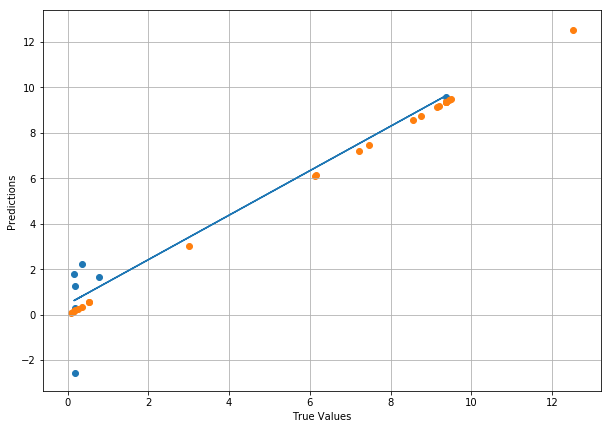

In [27]:
# Define PLS object
pls =  PLSRegression(n_components=18)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# VIP filter selection

In [159]:
a= _calculate_vips(pls)
print(a)
b=[]
for i in range(len(a)):
    if a[i]> 1.21:
        b.append(i)

x_selecta = pd.DataFrame(x_df.values[:,b])
print(x_selecta.shape)

[1.28229721 1.21217475 1.17745189 ... 1.45493084 1.17456334 1.23178447]
(24, 210)


37% completed
Suggested number of components:  5



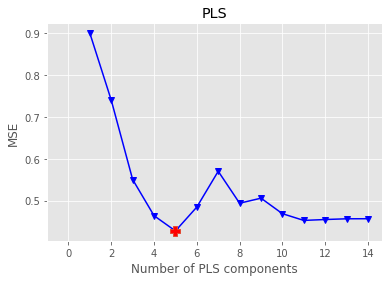

R2 calib: 0.962
R2 CV: 0.570
MSE calib: 0.038
MSE CV: 0.428


In [160]:
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)

optimise_pls_cv(X_train, y_train, 15, plot_components=True) 

R2_pred:  -0.3690216841795315
RMSE:  1.755614582771907



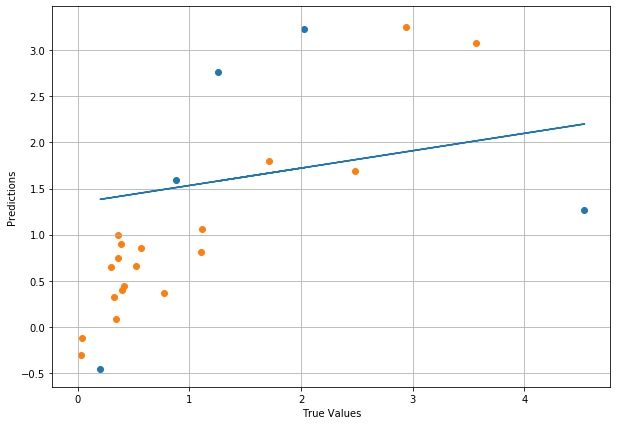

In [23]:
# Define PLS object
pls =  PLSRegression(n_components=3)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# wavelength selection with *i*-PLS 
NIRpy function

In [ ]:
start_time = time.time()
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_selecta.values, y_val, 15)
#opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_val, 15)
print("--- %s seconds ---" % (time.time() - start_time))

print("sorted wavelengths: ", wl[sorted_ind[:10]].T)

plt.plot(opt_Xc.T)
plt.show()

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

In [ ]:
optimise_pls_cv(X_train,y_train, 40, plot_components=True)

In [ ]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Genetic Algorithm with PLS

In [15]:
# GA settings
number_of_population = 200
number_of_generation = 100
max_number_of_components = 10
fold_number = 5
probability_of_crossover = 0.5
probability_of_mutation = 0.01
threshold_of_variable_selection = 0.5

# input
X_train=values
y_train= y_val

#autoscaled_X_train= X_train
#autoscaled_y_train=y_train

autoscaled_X_train= (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
autoscaled_y_train = (y_train - y_train.mean()) / y_train.std(ddof=1)
#print(autoscaled_X_train.shape)
#print(autoscaled_y_train.shape)

#genetic_algorithm(autoscaled_X_train,autoscaled_y_train)

(34, 3648)
(34,)
33


In [25]:
x_selecta = pd.DataFrame(x_df.values[:,selected_X_variable_numbers])

In [103]:
#X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = 3) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(27, 348) (27, 1)
(7, 348) (7, 1)
       0
10  11.2
30  19.9
1     18
2   21.1
31    14
33  24.4
16   8.4


37% completed
Suggested number of components:  2



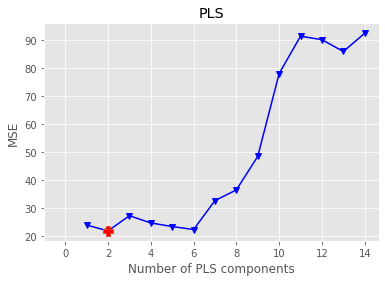

R2 calib: 0.349
R2 CV: 0.101
MSE calib: 15.815
MSE CV: 21.849


In [104]:
optimise_pls_cv(X_train, y_train, 15, plot_components=True) 

R2_pred:  -0.09441884308116721
RMSE:  1.4843109346366985



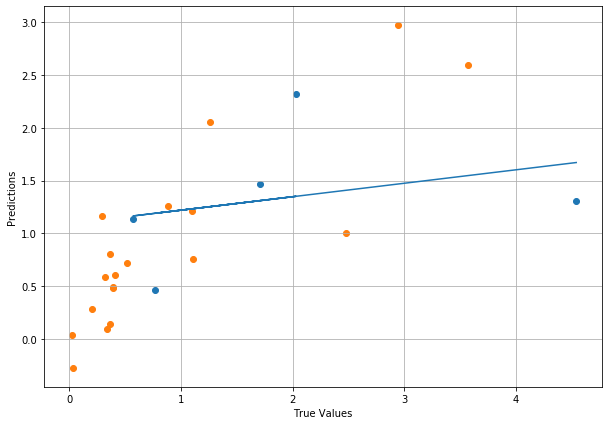

In [30]:
# Define PLS object
pls =  PLSRegression(n_components=3)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [25]:
start_time = time.time()

opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_selecta.values, y_val, 15)
#opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_val, 15)

print("--- %s seconds ---" % (time.time() - start_time))

100% completed
Optimised number of PLS components:  12
Wavelengths to be discarded  177
Optimised MSEP  0.4391647684828197

--- 32.15109443664551 seconds ---


sorted wavelengths:  [271.5639 272.3414 262.0899 257.669  264.8179 271.9527 261.3101 264.1685
 265.0776 253.1133]


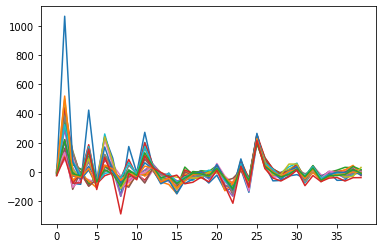

In [26]:
#print(opt_Xc.shape,"\n")
#print("sorted indexes: ", sorted_ind)
print("sorted wavelengths: ", wl[sorted_ind[:10]].T)

plt.plot(opt_Xc.T)
plt.show()

In [44]:
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 39) (19, 1)
(5, 39) (5, 1)
        0
19  0.339
5   0.360
23  2.030
21  2.480
12  0.320


100% completed
Suggested number of components:  14



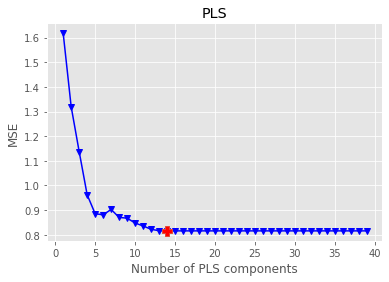

R2 calib: 1.000
R2 CV: 0.452
MSE calib: 0.000
MSE CV: 0.816


In [45]:
optimise_pls_cv(X_train,y_train, 40, plot_components=True)

R2_pred:  0.7360721453243093
RMSE:  0.4876059430361719



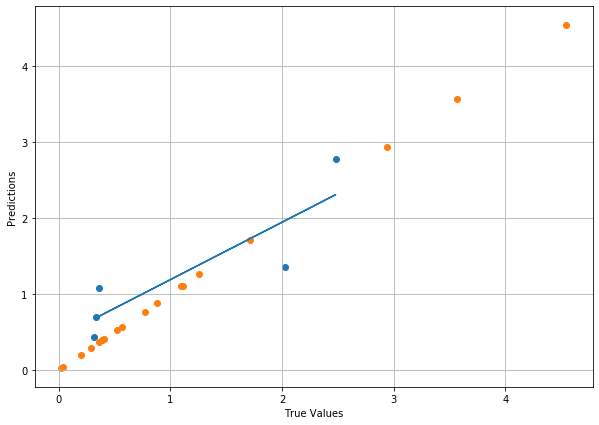

In [47]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

Best ones so far:

#1
number_of_population = 150
number_of_generation = 100
max_number_of_components = 10
fold_number = 5
probability_of_crossover = 0.5
probability_of_mutation = 0.3
threshold_of_variable_selection = 0.6


#2
number_of_population = 150
number_of_generation = 100
max_number_of_components = 10
fold_number = 5
probability_of_crossover = 0.5
probability_of_mutation = 0.25
threshold_of_variable_selection = 0.5


# Elastic Net

In [28]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.83, MSE:1.34, RMSE:1.16
Alpha:0.0010, R2:0.83, MSE:1.34, RMSE:1.16
Alpha:0.0100, R2:0.83, MSE:1.34, RMSE:1.16
Alpha:0.1000, R2:0.83, MSE:1.33, RMSE:1.15
Alpha:0.3000, R2:0.83, MSE:1.32, RMSE:1.15
Alpha:0.5000, R2:0.83, MSE:1.32, RMSE:1.15
Alpha:0.7000, R2:0.83, MSE:1.31, RMSE:1.14
Alpha:1.0000, R2:0.83, MSE:1.30, RMSE:1.14


In [29]:
model = ElasticNet(alpha=0.0001).fit(X_train,y_train)   
score = model.score(X_train, y_train)
print("Train score: ", score)
pred_y = model.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, pred_y))
r2 = r2_score(y_test, pred_y)
print("RMSE: ", rmse)
print("R^2: ", r2)

Train score:  0.8284647883737228
RMSE:  1.156219072947733
R^2:  0.7573130383682116


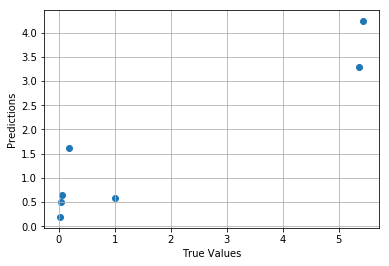

In [30]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Random Forest

In [24]:
#X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.15)
X_train, X_test, y_train, y_test = train_test_split(principalComponents, y_df, test_size=0.15)


print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(y_test)

(20, 20) (20, 1)
(4, 20) (4, 1)


In [31]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(7,)
(24,)


RMSE:  1.7339715593844924
R^2:  0.4541791444235702 

[real, predictions]
[[1.011 0.9078559999999976]
 [5.37 2.0503199999999993]
 [0.18 0.6055359999999989]
 [0.052000000000000005 0.565691999999997]
 [0.031 0.17300800000000005]
 [5.44 2.376215999999997]
 [0.02 0.42470800000000014]]


Text(0, 0.5, 'Predictions')

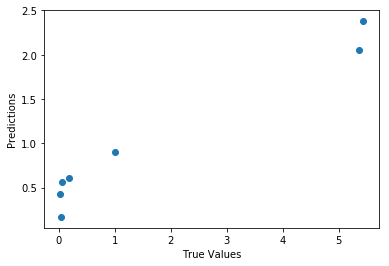

In [32]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 250, max_depth=30, random_state = 42)
# Train the model on training data

rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("RMSE: ", rmse)
print("R^2: ", r2, "\n")

y_test= y_test.reshape((len(y_test), 1))
predictions=predictions.reshape((len(y_test), 1))
#print((y_test, predictions))

b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# MultiOutput Random Forest

In [132]:
multi_y = concentration[:,1:-2]
print (multi_y.shape)
print (type(multi_y))
df_y= pd.DataFrame(multi_y)
print (type(df_y))

(24, 6)
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [153]:
X_train, X_test, y_train, y_test = train_test_split(x_df, df_y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1130) (19, 6)
(5, 1130) (5, 6)


In [134]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=650,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=30,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=650,
                                                

In [135]:
y_multirf = regr_multirf.predict(X_test)

In [136]:
print(y_test.shape)
print(y_multirf.shape)

(5, 6)
(5, 6)


In [137]:
rmse = sqrt(mean_squared_error(y_test, y_multirf))
r2 = r2_score(y_test, y_multirf)

print("R^2: ", r2)
print("RMSE: ", rmse)

R^2:  -1.2798201186343863
RMSE:  1.5231794557929577


In [138]:
b=np.append(np.around(y_test,3), np.around(y_multirf,3), axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[6.160e+00 0.000e+00 3.630e-01 0.000e+00 6.000e-03 2.060e-01 8.711e+00
  2.880e-01 4.460e-01 2.870e-01 7.790e-01 1.910e-01]
 [6.120e+00 0.000e+00 3.200e-01 0.000e+00 5.000e-03 1.600e-02 8.009e+00
  2.150e-01 4.630e-01 8.500e-02 1.110e-01 1.440e-01]
 [1.253e+01 3.100e-01 2.500e-02 5.000e-02 5.600e-02 3.300e-02 7.822e+00
  2.570e-01 2.970e-01 1.650e-01 1.750e-01 2.170e-01]
 [1.800e-01 5.000e-01 1.110e+00 5.200e-02 1.500e-01 1.260e+00 4.830e-01
  3.630e-01 1.233e+00 2.260e-01 1.360e-01 9.710e-01]
 [1.290e+01 1.200e-01 5.200e-01 1.550e-01 5.200e-01 2.860e-01 6.898e+00
  3.360e-01 7.140e-01 1.420e-01 5.610e-01 2.290e-01]]


Text(0, 0.5, 'Predictions')

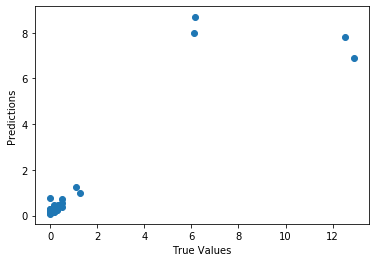

In [139]:
plt.scatter(y_test, y_multirf)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [141]:
y_pred=np.around(y_multirf,2)
y_pred[:,0]

array([8.71, 8.01, 7.82, 0.48, 6.9 ])

In [142]:
y_test[0].values

array([ 6.16,  6.12, 12.53,  0.18, 12.9 ])

In [143]:
print("real: ", y_test[0].values)
print("pred: ", y_pred[:,0])

real:  [ 6.16  6.12 12.53  0.18 12.9 ]
pred:  [8.71 8.01 7.82 0.48 6.9 ]


# PLS-2

100% completed
Suggested number of components:  33



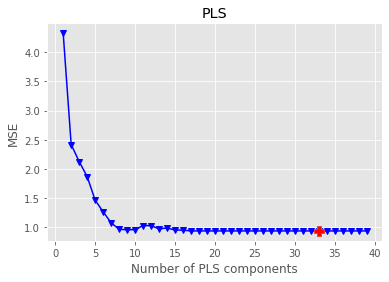

R2 calib: 1.000
R2 CV: 0.018
MSE calib: 0.000
MSE CV: 0.939


In [154]:
optimise_pls_cv(X_train, y_train, 40, plot_components=True)

In [155]:
# Define PLS object
pls = PLSRegression(n_components= 26)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
# Calculate scores
score = r2_score(y_train, y_cv)
mse = mean_squared_error(y_train, y_cv)

print("R^2: ", score)
print("MSE: ", mse)

R^2:  0.018347253779067135
MSE:  0.9391318844120397


In [150]:
y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print(score_pred) #NAMMERDA
print(score_cv)

-4.070272705754876
0.36555579763038115


In [151]:
pd.DataFrame(np.round(y_pred, decimals=2))

,0,1,2,3,4,5
0,7.84,0.22,0.54,0.19,0.57,0.27
1,8.62,0.12,0.35,0.06,-0.12,-0.06
2,10.50,0.13,-0.61,0.45,0.15,-0.03
3,-0.28,0.42,1.56,-0.11,-0.34,0.95
4,9.93,0.09,0.29,-0.26,0.65,0.14


In [152]:
np.round(y_test, decimals=2)

,0,1,2,3,4,5
20,6.16,0.00,0.36,0.00,0.01,0.21
12,6.12,0.00,0.32,0.00,0.01,0.02
13,12.53,0.31,0.02,0.05,0.06,0.03
22,0.18,0.50,1.11,0.05,0.15,1.26
7,12.90,0.12,0.52,0.16,0.52,0.29
